# Get the Data

In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [261]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2.16.1
3.0.5


## Define global constants

In [262]:
MY_OPTIMIZER = "Adam"
MY_EPOCHS = 25
#MY_LEARNING_RATE = 0.1

# Get the Data

In [263]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()
maneuvers.shape

(2344, 8)

In [264]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,2344.000000,2344.000000,2.344000e+03,2344.000000,2.344000e+03,2344.000000,2.344000e+03,2.344000e+03
mean,7548.350621,-0.990424,-5.895742e-07,-0.000168,-4.952150e-07,-0.000011,2.453067e-07,1.729460e-08
std,4349.693426,0.001021,3.212275e-03,0.000715,2.139333e-03,0.006607,1.474166e-03,2.512213e-08
min,19.280590,-0.991668,-4.523862e-03,-0.001139,-3.247579e-03,-0.009040,-2.084719e-03,-2.785758e-08
25%,3783.815250,-0.991459,-3.224401e-03,-0.000878,-1.993437e-03,-0.006529,-1.487002e-03,-2.321468e-09
50%,7548.350500,-0.990587,-1.529082e-05,-0.000219,-5.756147e-06,-0.000394,6.194265e-06,1.033334e-08
75%,11312.887500,-0.989400,3.228971e-03,0.000540,1.972725e-03,0.006461,1.480479e-03,3.709943e-08
max,15077.420000,-0.988843,4.523994e-03,0.000913,3.247771e-03,0.009939,2.084456e-03,7.822104e-08


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [265]:
#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)

# Prepare the Data for Machine Learning Algorithms

In [266]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,dx,dy,dz
0,-0.989189,0.002520,-0.000968,0.002222,-0.007492,-0.001014
1,-0.988843,-0.000112,-0.001121,-0.000103,-0.009031,0.000045
2,-0.989246,-0.002703,-0.000941,-0.002366,-0.007233,0.001091
3,-0.990157,-0.004300,-0.000479,-0.003245,-0.002797,0.001838
4,-0.991066,-0.004307,0.000136,-0.002407,0.002813,0.002033


## Create a Train/Test/Validation Set

In [267]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
X_train.head()

(1406, 6)
(469, 6)
(469, 6)


,x,y,z,dx,dy,dz
1470,-0.989271,-0.002778,-0.000940,-0.002424,-0.007124,0.001134
907,-0.991312,-0.003860,0.000368,-0.001811,0.004895,0.001917
626,-0.988850,-0.000386,-0.001123,-0.000354,-0.009002,0.000154
1910,-0.991660,-0.000821,0.000891,-0.000177,0.009748,0.000463
950,-0.991164,0.004174,0.000222,0.002200,0.003582,-0.002015


In [268]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:5]

array([[0.84846876, 0.19296129, 0.09726012, 0.12680394, 0.10096634,
        0.77202396],
       [0.12572137, 0.07333063, 0.7346112 , 0.22110926, 0.73424112,
        0.95987144],
       [0.99730926, 0.45732341, 0.00803411, 0.44543082, 0.00199891,
        0.53688965],
       [0.00265534, 0.40923385, 0.98972711, 0.47269579, 0.98997921,
        0.61118463],
       [0.17819083, 0.9613031 , 0.66370598, 0.83864672, 0.66507173,
        0.01680332]])

In [269]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_valid_scaled = scaler.transform(y_valid)
y_test_scaled = scaler.transform(y_test)

# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [270]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train_scaled.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 300)            │         2,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,301 (126.18 KB)

 Trainable params: 32,301 (126.18 KB)

 Non-trainable params: 0 (0.00 B)

In [271]:
model.compile(loss="mean_squared_error", optimizer=MY_OPTIMIZER)
history = model.fit(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, 
                    validation_data=(X_valid_scaled, y_valid_scaled))

Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0809 - val_loss: 0.0146
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - val_loss: 0.0070
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0040
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 9/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 11/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 12/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_lo

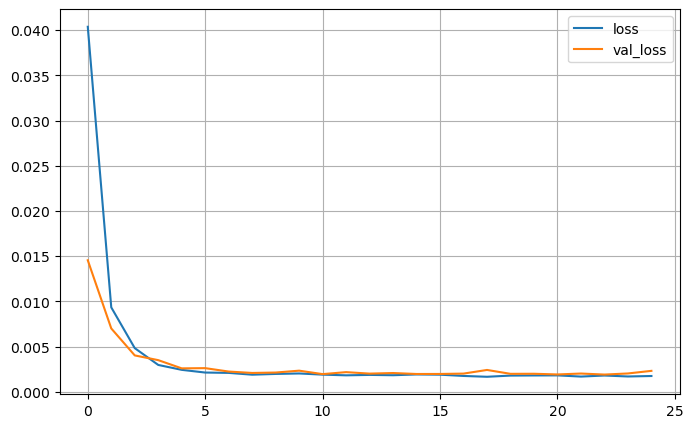

In [272]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 5e-4) # set the vertical range to [0-1]
plt.show()

In [273]:
mse_test = model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 0.0024


0.048761300613473425

In [274]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [275]:
y_test_scaled[:3]

array([[0.33555265],
       [0.8778853 ],
       [0.57676551]])

In [276]:
y_pred[:3]

array([[0.37231627],
       [0.7743877 ],
       [0.523182  ]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [277]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        optimizer=MY_OPTIMIZER,
        loss="mean_squared_error",
    )
    return model


In [278]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid_scaled . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train_scaled, epochs=100,
                  validation_data=(X_valid, y_valid_scaled),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [279]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [280]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [281]:
tuner.search(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, validation_data=(X_valid_scaled, y_valid_scaled))

Trial 6 Complete [00h 00m 08s]
val_loss: 0.0018134035053662956

Best val_loss So Far: 0.0017022068495862186
Total elapsed time: 00h 00m 45s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
2                 |5                 |num_layers
32                |32                |units_0
32                |416               |units_1
64                |64                |units_2
448               |64                |units_3
64                |512               |units_4

Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1718 - val_loss: 0.0251
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - val_loss: 0.0108
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - val_loss: 0.0070
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0

KeyboardInterrupt: 

## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

In [ ]:
tuner.results_summary()

In [ ]:
mse_test = best_model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

In [ ]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = best_model.predict(X_new)

In [ ]:
y_test_scaled[:3]

In [ ]:
y_pred[:3]